In [104]:
import sys
import pandas as pd
sys.path.append("..")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploratory Data Analysis


## Cohort ROI - Mathematical Formulation

We define a **cohort** $c$, created at time $t=0$. For each loan $i \in c$:

- $L_i $: principal loan amount granted.  
- $R_i(t) $: cumulative repayments (including normal repayments and collections) up to time $t$.  
- $L_i$ : amount of loan $i$.

The **net cash flow** $F_i$ of loan $i$ up to time $t$ is:

$$
F_i(t) = R_i(t) - L_i
$$

The **net cash flow of cohort $c$** up to time $t$ is:

$$
F_c(t) = \sum_{i \in c} F_i(t) = \sum_{i \in c} \big(R_i(t) - L_i\big)
$$

The **Return on Investment (ROI)** for cohort $c$ up to time $t$ is defined as:

$$
ROI_c(t) = \frac{F_c(t)}{\sum_{i \in c} L_i}
$$

or equivalently:

$$
ROI_c(t) = \frac{\sum_{i \in c} R_i(t)}{\sum_{i \in c} L_i} - 1
$$

### Properties

- At the start ($t=0$), repayments are zero, so $ROI_c(0) = -1$.  
- As repayments occur, $ROI_c(t)$ increases.  
- If $ROI_c(t) > 0$, the cohort has become profitable at horizon $t$.  

## Computing ROI curves

The initial step involves creating a consolidated table that combines repayment data, loan details, and batch identifiers. This comprehensive table will enable us to group repayments by batch and subsequently calculate the Return on Investment (ROI) curves for each cohort.

In [105]:
from src.data_loading import load_data

# Load and prepare all data
allowlist, loans, repayments, loans_and_cohort, repayments_and_loans = load_data("../database.db")

In [106]:
# Dataframe of loans with cohort information
display(loans_and_cohort.head())

,loan_id,user_id,created_at,updated_at,annual_interest,loan_amount,status,batch,allowlisted_date
0,561fb48b1bcc88cdb406cb4e31aedc10735ab76b57ca8e...,83340eac06d22f039113479a1cdddd88c6015af7a51eb7...,2023-12-06,2023-12-06 20:50:26.060000+00:00,3.2,500.0,executed,4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640...,2023-12-05
1,561fb48b1bcc88cdb406cb4e31aedc10735ab76b57ca8e...,83340eac06d22f039113479a1cdddd88c6015af7a51eb7...,2023-12-06,2023-12-06 20:50:26.049000+00:00,3.2,500.0,executed,4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640...,2023-12-05
2,561fb48b1bcc88cdb406cb4e31aedc10735ab76b57ca8e...,83340eac06d22f039113479a1cdddd88c6015af7a51eb7...,2023-12-06,2023-12-22 07:25:57.889000+00:00,3.2,500.0,repaid,4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640...,2023-12-05
3,561fb48b1bcc88cdb406cb4e31aedc10735ab76b57ca8e...,83340eac06d22f039113479a1cdddd88c6015af7a51eb7...,2023-12-06,2023-12-06 20:54:10.858000+00:00,3.2,500.0,executed,4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640...,2023-12-05
4,03bd8fb1f4c0504c2c97da9a059fcf4df1f5b60caef436...,83340eac06d22f039113479a1cdddd88c6015af7a51eb7...,2023-12-22,2023-12-22 13:41:48.169000+00:00,3.2,500.0,executed,4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640...,2023-12-05


In [107]:
# Dataframe of repayments with loans and cohort information, 
# we also have historical status of each loan
display(repayments_and_loans.head())

,date,loan_id,repayment_amount,billings_amount,batch,allowlisted_date
0,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
1,2022-12-13,059f1d15ef6b5990280bb37efb4325b71b1d3b68c9c847...,0.0,71.88,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
2,2022-12-13,bfde49d91ce96adc8b2f04a25850c929f6688d81e26b06...,0.0,1312.95,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
3,2022-12-13,c1636359078ef9fc7a37aacb4afba4610d2492c1769d24...,0.0,344.18,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29
4,2022-12-13,6cc14f085ec7834225629bc7e619d1d1bc03b36b1f5349...,0.0,98.07,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29


Now, let's create three important columns:
- **cohort_start:** the date when the user was allowlisted
- **h_days:** the number of days since the cohort_start until the repayment date
- **repayment_total:** the total amount repaid by the user, including both normal repayments and collections.

In [108]:
from src.data_loading import prepare_roi_columns

# Prepare additional columns for ROI calculations
repayments_and_loans = prepare_roi_columns(repayments_and_loans)

display(repayments_and_loans.head())

,date,loan_id,repayment_amount,billings_amount,batch,allowlisted_date,cohort_start,h_days,repayment_total
0,2022-12-13,66fb058ba3d8436e498813f940534410a2cbe63bca8c1d...,0.0,0.15,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29,2022-08-29,106,0.15
1,2022-12-13,059f1d15ef6b5990280bb37efb4325b71b1d3b68c9c847...,0.0,71.88,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29,2022-08-29,106,71.88
2,2022-12-13,bfde49d91ce96adc8b2f04a25850c929f6688d81e26b06...,0.0,1312.95,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29,2022-08-29,106,1312.95
3,2022-12-13,c1636359078ef9fc7a37aacb4afba4610d2492c1769d24...,0.0,344.18,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29,2022-08-29,106,344.18
4,2022-12-13,6cc14f085ec7834225629bc7e619d1d1bc03b36b1f5349...,0.0,98.07,1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f...,2022-08-29,2022-08-29,106,98.07


Now, we need to compute the loan amount per batch.

In [109]:
from src.data_manipulation import compute_cohort_principal

cohort_principal = compute_cohort_principal(loans_and_cohort)
display(cohort_principal)

batch
1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e2157841bfff5fa732465      786691.62
1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f3741fe1eac98731f61    22463415.15
22bda9c4992b30b6b347e22c27f9e59fb9ce99f1072389373820e5ed747bdd71    30658758.56
4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640b4e0e049e7a95e8e7f     2587785.26
5bcbc3d39978a3ff54a2671faf77e3e43c798faf53e98f6d27810f35a57346a1    14060518.80
9a65c2254d6d2b240f353b95df7061928c7a9869417325770f461463271a3b65     8349103.51
e6a25e071c60243b0c51c698db5302b54ef61338c6747a79598215f4d982028b     3648047.60
Name: cohort_principal, dtype: float64

Now, let's group the loans by batch and days since cohort start, summing the repayments. Then, we will compute the cumulative sum of repayments over time for each batch. Finally, we will merge the cumulative repayments with the principal amounts to calculate the ROI for each cohort over time.

In [110]:
from src.data_manipulation import compute_roi_curves

roi_curves_df = compute_roi_curves(repayments_and_loans, cohort_principal)

In [111]:
display(roi_curves_df.head(10))

,batch,h_days,repayment_total,cohort_principal,ROI
0,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,0,200.880000,786691.62,-0.999745
1,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,1,812.270000,786691.62,-0.998967
2,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,2,2685.620000,786691.62,-0.996586
3,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,3,2916.920000,786691.62,-0.996292
4,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,4,5725.787277,786691.62,-0.992722
5,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,5,8275.687966,786691.62,-0.989480
6,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,6,9802.077703,786691.62,-0.987540
7,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,7,10489.405727,786691.62,-0.986666
8,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,8,12559.529520,786691.62,-0.984035
9,1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e21...,9,14277.950965,786691.62,-0.981851


Now, we can iterate over each batch to plot the ROI curves.

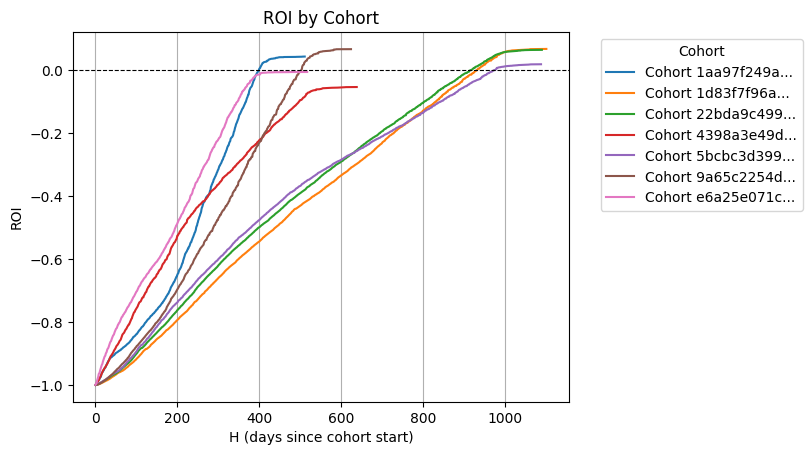

In [112]:
from src.plot.roi import plot_roi_curves

_ = plot_roi_curves(roi_curves_df)

Based on this graph, we can see that out of the 7 cohorts analyzed, 5 are profitable. Two of them became profitable after about 400–500 days, while the other 3 did so after approximately 1000 days.

Given this observation, it is advisable to consider a horizon H of 1000–1200 days to ensure we capture the profitability of all cohorts.

All cohorts exhibit a strictly increasing, monotonic behavior, with a plateau near the end of the data records. The derivative remains almost constant throughout most observations, but varies abruptly at the beginning of the plateau.

## Correlation of results
**Answering to the question:** 

"Do loans within the same cohort being predominantly repaid increase the chance that a particular loan will be repaid?"

### Modeling loan repayment probability as a function of cohort repayment rate

We can model the probability of loan repayment as a function of the cohort repayment rate using logistic regression. The cohort repayment rate serves as a predictor variable, while the individual loan repayment status (repaid or not) is the response variable.

Let Y be a binary variable indicating whether a loan is repaid (1) or not (0).

Let X be the cohort repayment rate, defined as the proportion of loans in the cohort that have been repaid.

Our model can be expressed as:
$$
P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X)}}
$$



In [113]:
# Checking loans last status
loans_last_status = loans_and_cohort.sort_values('updated_at').drop_duplicates(subset=['loan_id'], keep='last')
loans_last_status['status'].value_counts()

status
repaid                 40114
debt_collection         2722
debt_repaid             2529
manual_cancellation       14
cancelled                  2
Name: count, dtype: int64

In [119]:
loans_to_consider = loans_last_status[loans_last_status.status.isin(["repaid", "debt_repaid", "debt_collection"])].copy()

# Computing Y variable (loan payed or not)
loans_to_consider.loc[:,"payed"] = loans_to_consider["status"].apply(lambda x: 0 if x == "debt_collection" else 1)

# Computing X (batch repayment rate)
loans_to_consider.loc[:, "batch_repayment_rate"] = loans_to_consider.groupby("batch")["payed"].transform("mean")

display(loans_to_consider.head())

,loan_id,user_id,created_at,updated_at,annual_interest,loan_amount,status,batch,allowlisted_date,payed,batch_repayment_rate
23308,5ef1e83bf3e1b5f4f46cebae0373c75e98812be1620fa9...,3c853ad3cc27407ec3f77eb19cdba4f9354a9c39dbc4e9...,2022-09-11,2022-10-10 12:42:27.332963+00:00,1.7,5000.0,repaid,5bcbc3d39978a3ff54a2671faf77e3e43c798faf53e98f...,2022-09-09,1,0.917563
2096,cbb6861b6c7c1ef1a5ff792f96469cd78883185c3e686c...,03ef881ec8c224c62a7ea08f65531c6962af5c4482a018...,2022-10-05,2022-10-10 12:42:27.332963+00:00,1.7,1000.0,repaid,22bda9c4992b30b6b347e22c27f9e59fb9ce99f1072389...,2022-09-09,1,0.947773
38529,8cf509bc0d9fbb8adf491e1a40d843682355afdef421b1...,57ca236251f20683f39ae100587112e675c35c8506d069...,2022-09-20,2022-10-10 12:42:27.332963+00:00,1.7,1800.0,repaid,5bcbc3d39978a3ff54a2671faf77e3e43c798faf53e98f...,2022-09-09,1,0.917563
38524,cf2b109c2dc9f7e7ed1d159f076364725c15b6319c1bbe...,57ca236251f20683f39ae100587112e675c35c8506d069...,2022-09-15,2022-10-10 12:42:27.332963+00:00,1.7,1000.0,repaid,5bcbc3d39978a3ff54a2671faf77e3e43c798faf53e98f...,2022-09-09,1,0.917563
38525,c5e9b9a20d58203c47c2906a7062884b2c92959f44cd61...,57ca236251f20683f39ae100587112e675c35c8506d069...,2022-09-17,2022-10-10 12:42:27.332963+00:00,1.7,2500.0,repaid,5bcbc3d39978a3ff54a2671faf77e3e43c798faf53e98f...,2022-09-09,1,0.917563


In [120]:
# Fitting the model
from statsmodels.api import Logit
from statsmodels.tools import add_constant

X = loans_to_consider[["batch_repayment_rate"]]
y = loans_to_consider["payed"]
X = add_constant(X)

model = Logit(y, X).fit()

display(model.summary())

Optimization terminated successfully.
         Current function value: 0.210481
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  payed   No. Observations:                45365
Model:                          Logit   Df Residuals:                    45363
Method:                           MLE   Df Model:                            1
Date:                qui, 18 set 2025   Pseudo R-squ.:                 0.07266
Time:                        13:57:24   Log-Likelihood:                -9548.5
converged:                       True   LL-Null:                       -10297.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -8.2504      0.262    -31.499      0.000      -8.764      -7.737
batch_repayment_rate    11.9141      0.289     41.253      0.000      11.348      12.480
========================================================================================
"""

The results show a weak fit of the model, with a pseudo R-squared of 0.07.

The coefficient for batch_repayment_rate is positive and significant, indicating that higher batch repayment rates are associated with a higher likelihood of individual loan repayment, however, this just explains a small part of the variability in loan repayment outcomes.

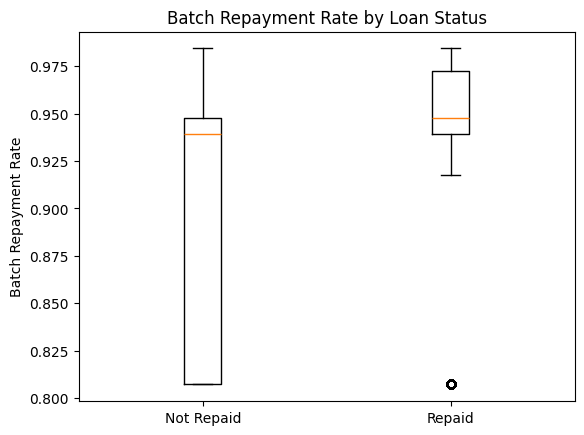

In [121]:
from matplotlib import pyplot as plt

plt.boxplot([loans_to_consider["batch_repayment_rate"][loans_to_consider["payed"] == 0],
              loans_to_consider["batch_repayment_rate"][loans_to_consider["payed"] == 1]],
             tick_labels=["Not Repaid", "Repaid"])
plt.title("Batch Repayment Rate by Loan Status")
plt.ylabel("Batch Repayment Rate")
plt.show()

This boxplot reinforces what was predicted by the logistic regression model. The medians between the two groups are similar, however, the interquartile range between Q1 and median for the "Not Repaid" group is much larger than that of the "Repaid" group. This indicates that loans that were not repaid tend to belong to cohorts with lower repayment rates, while loans that were repaid are more likely to be part of cohorts with higher repayment rates.

## Sensitivity to large loans

"How much do top exposures move the ROI curve?"

To answer this question, we can perform a sensitivity analysis by excluding the top 5% of loans by amount and recalculating the ROI curves for each cohort.

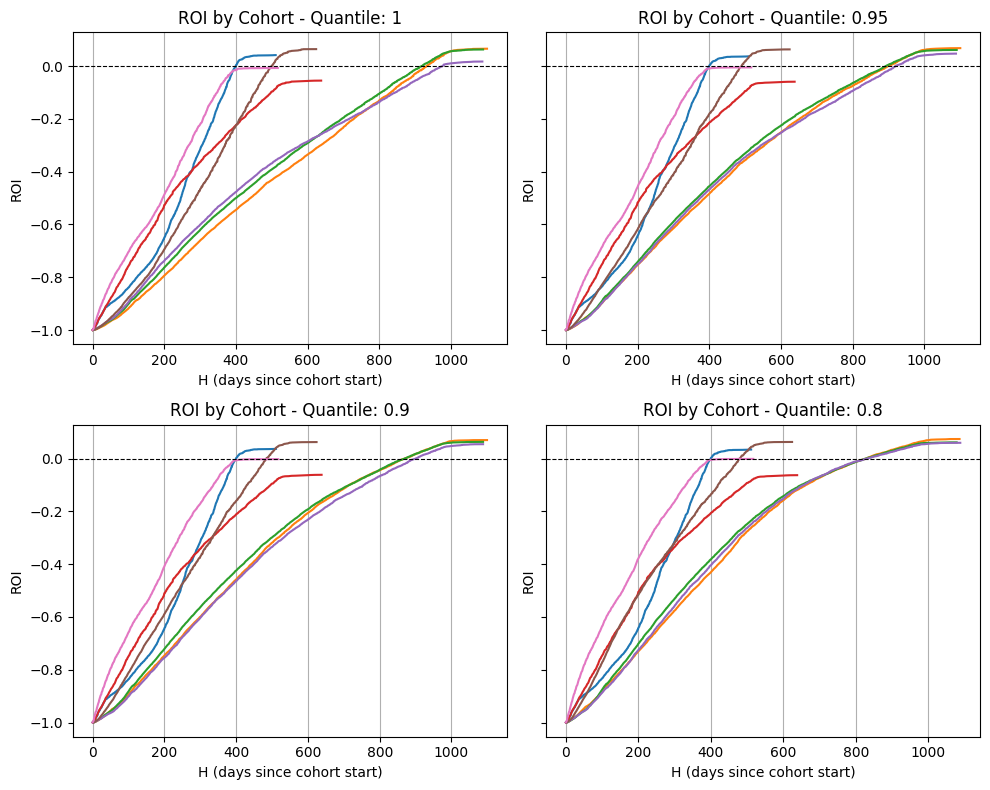

In [117]:
from src.plot.roi import plot_roi_curves

quantiles = [1, 0.95, 0.9, 0.8]
roi_curves = {}

for q in quantiles:
    threshold = loans_last_status['loan_amount'].quantile(q)
    no_top_loans = loans_last_status[loans_last_status['loan_amount'] < threshold]
    
    cohort_principal_no_top_loans = compute_cohort_principal(no_top_loans)
    
    roi_curve_no_top_loans = compute_roi_curves(
        repayments_and_loans[repayments_and_loans['loan_id'].isin(no_top_loans['loan_id'])],
        cohort_principal_no_top_loans
    )
    
    roi_curves[q] = roi_curve_no_top_loans

# Plotting the ROI curves for each quantile
fig, axs = plt.subplots(2, len(quantiles)//2, figsize=(10, 8), sharey=True)
for ax, (q, roi_curve) in zip(axs.flatten(), roi_curves.items()):
    plot_roi_curves(roi_curve, ax=ax, extra_title=f'Quantile: {q}', show_legend=False)

plt.tight_layout()
plt.show()

It's not possible to see a significant difference in the ROI curves after excluding the top 5%-20% of loans by amount.

## Collection sensitivity analysis

 How would changes in billing amounts affect the curve?

 Let's start by excluding all collection repayments and recalculating the ROI curves.

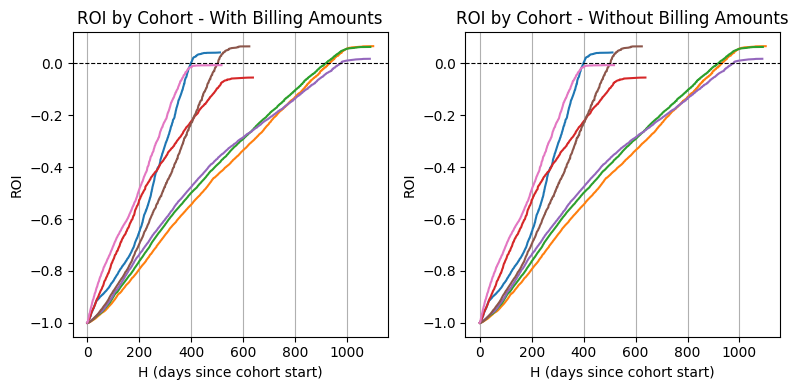

In [ ]:
repayments_and_loans_without_billing = repayments_and_loans.copy()
repayments_and_loans_without_billing["billings_amount"] = 0

roi_curves_df_no_billing = compute_roi_curves(
    repayments_and_loans_without_billing, cohort_principal
)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

data_to_plot = [roi_curves_df, roi_curves_df_no_billing]
for i, ax in enumerate(ax.flatten()):
    _ = plot_roi_curves(
        data_to_plot[i],
        ax=ax,
        extra_title=["With Billing Amounts", "Without Billing Amounts"][i],
        show_legend=False,
    )
plt.tight_layout()
plt.show()

It seems to have a very low impact, to confirm that, let's compute how much money was repaid through normal repayments and how much through collections.

In [135]:
batch_sums = repayments_and_loans.groupby("batch")[["repayment_amount", "billings_amount"]].sum()
batch_sums["total_repaid"] = batch_sums["repayment_amount"] + batch_sums["billings_amount"] 
batch_sums["normal_ratio"] = batch_sums["repayment_amount"] / batch_sums["total_repaid"] * 100
batch_sums["collections_ratio"] = batch_sums["billings_amount"] / batch_sums["total_repaid"] * 100
batch_sums["ROI"] = batch_sums["total_repaid"] / loans_last_status.groupby("batch")["loan_amount"].sum() - 1
display(batch_sums[["normal_ratio", "collections_ratio", "ROI"]])

,normal_ratio,collections_ratio,ROI
batch,,,
1aa97f249a5324861f6c93ab68cfde742ed9ff35dd3e2157841bfff5fa732465,96.011026,3.988974,0.041997
1d83f7f96a6a3a06b30bc683b94a428225fe072e60959f3741fe1eac98731f61,95.561787,4.438213,0.066219
22bda9c4992b30b6b347e22c27f9e59fb9ce99f1072389373820e5ed747bdd71,95.831419,4.168581,0.063262
4398a3e49d78f4b1b816ced315f34a5da5e830b1f53640b4e0e049e7a95e8e7f,91.107886,8.892114,-0.054692
5bcbc3d39978a3ff54a2671faf77e3e43c798faf53e98f6d27810f35a57346a1,91.872120,8.127880,0.017566
9a65c2254d6d2b240f353b95df7061928c7a9869417325770f461463271a3b65,97.294329,2.705671,0.065454
e6a25e071c60243b0c51c698db5302b54ef61338c6747a79598215f4d982028b,93.821475,6.178525,-0.006992


Collections represent a small portion of the total repayments across all batches. Most batches have a normal repayment ratio above 90%, indicating that the majority of repayments come from regular payments rather than collections.

Lets look the correlation between collections repayment ratio and ROI.

                            OLS Regression Results                            
Dep. Variable:                    ROI   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.697
No. Observations:                   7   F-statistic:                     14.79
Covariance Type:            nonrobust   Prob (F-statistic):             0.0121
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1216      0.026      4.636      0.006       0.054       0.189
collections_ratio    -0.0171      0.004     -3.846      0.012      -0.029      -0.006

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


c:\Users\vitor\git_repos\case-ds-cloud-walk\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


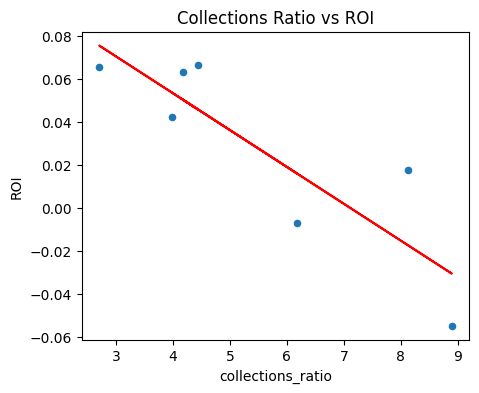

In [141]:

import statsmodels.api as sm

# Computing a linear regression model between collections ratio and ROI
X = sm.add_constant(batch_sums["collections_ratio"])
y = batch_sums["ROI"]
model = sm.OLS(y, X).fit()
print(model.summary(slim=True))

# Create the scatter plot
ax = batch_sums.plot(
    kind="scatter", x="collections_ratio", y="ROI", title="Collections Ratio vs ROI", figsize=(5,4)
)
ax.plot(batch_sums["collections_ratio"], model.predict(X), color='red')

The R-squared of 0.747 indicates that the collections ratio explains a substantial part of the variance in ROI. The negative coefficient (-0.0171) for the collections ratio is statistically significant (p = 0.012 < 0.05), despite having few observations, suggesting that higher collections ratios are associated with lower ROI.

And obviously, the opposite is also true: higher normal payement ratios are associated with higher ROI.

## Questions to answer, facts, and notes

**Facts**
- 1 - the repayment is not acumulative.
- 2 - alguns usuários não possuem empréstimos ativos, alguns batchs inteiros não possuem empréstimos.

**Questions**
- 1 - todos os emprestimos de um cohort começam a partir do inicio dele?